### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
States_track = collections.defaultdict(dict)
Q_dict = collections.defaultdict(dict)

In [4]:
def Q_state(state):
    return '-'.join(str(e) for e in state)

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(env, state):
    state_str = Q_state(state)
    if state_str not in Q_dict.keys():
        for action in env.action_space:
            Q_dict[state_str][action]=0

In [6]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [([1,2,3],(1,3)),([3,5,6],(2,4)),([4,10,2],(0,2)), ([2,7,0],(2,3))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = Q_state(q_values[0])
        action = q_values[1]
        States_track[state][action] = [] 

In [7]:
def save_tracking_states():
    """Saves the states to dictionary"""
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [8]:
initialise_tracking_states()

In [9]:
print(States_track)

defaultdict(<class 'dict'>, {'1-2-3': {(1, 3): []}, '3-5-6': {(2, 4): []}, '4-10-2': {(0, 2): []}, '2-7-0': {(2, 3): []}})


In [10]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01       
        self.epsilon = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01
        
        self.batch_size = 1000        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        
        model = Sequential()
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform')) 
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            return random.randrange(self.action_size)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            encoded_state = env.state_encod_arch1(state)
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])
        

    def append_sample(self, state, action, reward, next_state, done):
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
        
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            states, actions, rewards, done = [], [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                update_input[i] = env.state_encod_arch1(state)
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)  
                done.append(done_boolean)
                
            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.model.predict(update_output)                

            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])            
                Q_dict[Q_state(states[i])][env.action_space[actions[i]]] = target[i][actions[i]]
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)                
                

    def save(self, name):
        self.model.save(name)

In [12]:
Episodes = 400
m = 5  # number of cities, ranges from 0 ..... m-1
t = 24  # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
threshold = 100

In [13]:
import os
# make dir to store model weights
if not os.path.exists("saved_model_weights"):
    os.mkdir("saved_model_weights")

In [14]:
# to store rewards in each episode
rewards_per_episode, episodes = [], []

### DQN block

In [15]:
for episode in range(Episodes):
    
    tot_time = 0
    done = False
    score = 0
    
    env = CabDriver()
    action_space, state_space, state = env.reset()
    state_size = m+t+d
    action_size = len(action_space)
    agent = DQNAgent(state_size, action_size)

    while not done:
        
        # Write your code here
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state)
        # Add to the dictionary
        add_to_dict(env, state)
        # 2. Evaluate your reward and next state
        reward, next_state, total_time = env.step(state, env.action_space[action], Time_matrix)
        tot_time += total_time
        if tot_time >= 24*30:
            done = True
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, done)
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        #TRACKING Q-VALUES
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states() 
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')

In [16]:
print(States_track)

defaultdict(<class 'dict'>, {'1-2-3': {(1, 3): [0, 0, 0, 0]}, '3-5-6': {(2, 4): [0, 0, 0, 0]}, '4-10-2': {(0, 2): [0, 0, 0, 0]}, '2-7-0': {(2, 3): [0, 0, 0, 0]}})


### Tracking Convergence

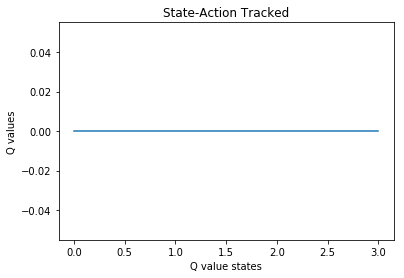

In [17]:
import matplotlib.pyplot as plt

plt.plot(States_track['1-2-3'][(1,3)])
plt.xlabel("Q value states")
plt.ylabel("Q values")
plt.title("State-Action Tracked")
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [18]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

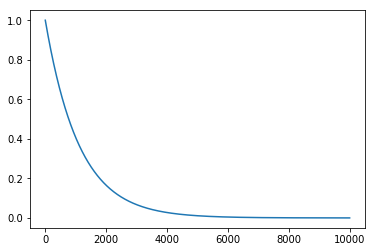

In [19]:
plt.plot(time, epsilon)
plt.show()